**Generate masks for coco dataset that has keypoint annotations**

Uses either SAM based onthe keypoints 
or PaliGemma to generate bboxes and then SAM conditioned on those bboxes.


Issues:

- SAM-H chekpoint not working, performance is a lot better though..
- PaliGemma bboxes are worse than JAX variants? bboxes are not good enough atm.

In [2]:
from segment_anything import SamPredictor, sam_model_registry
import tqdm 
from urllib.request import urlretrieve

from dsd import MODEL_CACHE

VIT_H_CHECKPOINT_PATH = "vit_h_4b8939.pth"
VIT_H_REMOTE_CHECKPOINT_URL = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth"

VIT_B_CHECKPOINT_PATH = "vit_b_01ec64.pth"
VIT_B_REMOTE_CHECKPOINT_URL = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth"

VIT_L_CHECKPOINT_PATH = "vit_l_0b3195.pth"
VIT_L_REMOTE_CHECKPOINT_URL = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth"


CHECKPOINT_CACHE = MODEL_CACHE / "sam"
CHECKPOINT_CACHE.mkdir(parents=True, exist_ok=True)


def load_sam_model(model_type: str = "vit_b"):
    if model_type == "vit_h":
        checkpoint_path = CHECKPOINT_CACHE / VIT_H_CHECKPOINT_PATH
        if not checkpoint_path.exists():
            urlretrieve(VIT_H_REMOTE_CHECKPOINT_URL, checkpoint_path)
    elif model_type == "vit_b":
        checkpoint_path = CHECKPOINT_CACHE / VIT_B_CHECKPOINT_PATH
        if not checkpoint_path.exists():
            urlretrieve(VIT_B_REMOTE_CHECKPOINT_URL, checkpoint_path)
    elif model_type == "vit_l":
        checkpoint_path = CHECKPOINT_CACHE / VIT_L_CHECKPOINT_PATH
        if not checkpoint_path.exists():
            urlretrieve(VIT_L_REMOTE_CHECKPOINT_URL, checkpoint_path)
    else:
        raise ValueError(f"model type {model_type} not supported")

    sam_model = sam_model_registry[model_type](checkpoint_path).cuda()
    sam_predictor = SamPredictor(sam_model)
    return sam_predictor


# vit_h checkpoint seems to be broken? is vit_s
sam_predictor = load_sam_model("vit_h")


In [3]:
from PIL import Image
from airo_dataset_tools.data_parsers.coco import CocoKeypointsDataset, CocoKeypointAnnotation, CocoImage
from airo_dataset_tools.segmentation_mask_converter import BinarySegmentationMask
import json 
import tqdm
import numpy as np

In [25]:
dataset_path = "/home/tlips/Documents/diffusing-synthetic-data/data/real/mugs/lab-mugs_resized_512x512/lab-mugs.json"
import pathlib

coco_dataset = CocoKeypointsDataset(**json.load(open(dataset_path, "r")))

# First attempt: SAM + keypoints

keypoints tend to lie on boundary of objects <-> SAM likes points on the objects. In general bbox based prompting seems to work better

In [4]:
len(coco_dataset.annotations)
image_id_to_image_dict = {image.id: image for image in coco_dataset.images}

In [5]:
# for i in tqdm.trange(0, len(coco_dataset.annotations)):
#     annotation = coco_dataset.annotations[i]
#     image_id = annotation.image_id
#     image_path = image_id_to_image_dict[image_id].file_name
#     image = Image.open(str(pathlib.Path(dataset_path).parent / image_path))
#     keypoints = annotation.keypoints
#     keypoints_uv = np.array([(keypoints[i], keypoints[i+1]) for i in range(0, len(keypoints), 3)])
    
#     # for shoes, add some non-edge keypoints fsor SAM!
#     barycentric_keypoint = np.mean(keypoints_uv, axis=0)
#     mid_nose_keypoint = np.mean(np.stack([keypoints_uv[1], barycentric_keypoint], axis=0), axis=0)
#     keypoints_uv = np.concatenate([keypoints_uv, [mid_nose_keypoint]], axis=0)
#     keypoints_uv = np.concatenate([keypoints_uv, [barycentric_keypoint]], axis=0)

#     # bbox = [min(keypoints_uv[:, 0]), min(keypoints_uv[:, 1]), max(keypoints_uv[:, 0]), max(keypoints_uv[:, 1])]
#     # ## padd the bbox, clip to image size
#     # padding = 100
#     # bbox = [max(0, bbox[0] - padding), max(0, bbox[1] - padding), min(image.size[0], bbox[2] + padding), min(image.size[1], bbox[3] + padding)]
    
#     sam_predictor.set_image(np.array(image))
#     mask,_,_ = sam_predictor.predict(
#         point_coords=keypoints_uv,
#         point_labels = np.array([1] * len(keypoints_uv)),
#         multimask_output=False,
#     )

#     mask = mask[0]

#     # use opencv to fill holes
#     import cv2
#     mask = mask.astype(np.uint8)  * 1
#     mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9,9)))
    
#     if i % 50 == 0:

#         # visualize the mask on the image

#         import matplotlib.pyplot as plt
#         # overaly the mask on the image
#         plt.imshow(image)
#         plt.imshow(mask, alpha=0.5)
#         # visulaize the bbox

#         # plt.plot([bbox[0], bbox[2], bbox[2], bbox[0], bbox[0]], [bbox[1], bbox[1], bbox[3], bbox[3], bbox[1]], color="red")

#         # visualize the keypoints
#         plt.scatter(keypoints_uv[:,0], keypoints_uv[:, 1], color="blue")
#         plt.show()
    

#     mask = mask > 0.5
#     mask = BinarySegmentationMask(mask)
#     annotation.segmentation = mask.as_compressed_rle
#     annotation.area = mask.area
#     annotation.bbox = mask.bbox

    

In [6]:
import requests
from PIL import Image

url = "https://huggingface.co/spaces/big-vision/paligemma/resolve/main/examples/cc_fox.jpg?download=true"
image = Image.open(requests.get(url, stream=True).raw)
image = Image.open("2024-06-11_15-58.png")
image = np.array(image)[...,:3]

# Second attempt: Open-vocab bbox detector + SAM 

In [7]:
from PIL import Image
import requests
import numpy as np 

image  =Image.open("2024-06-11_15-58.png")
image = np.array(image)[...,:3]


## PaliGemma 


there seems to be an issue with the torch models, bboxes are less accurate than for the original jax models? 
so finally went with Grounding Dino..

In [7]:

from transformers import AutoProcessor, PaliGemmaForConditionalGeneration
import torch


paligemma_processor = AutoProcessor.from_pretrained("google/paligemma-3b-mix-448")
paligemma_model = PaliGemmaForConditionalGeneration.from_pretrained("google/paligemma-3b-mix-448",device_map="cuda:0",revision="bfloat16",torch_dtype=torch.bfloat16).eval()



2024-06-13 16:21:57.619791: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-13 16:21:57.710773: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-13 16:21:59.033697: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [8]:
paligemma_model = paligemma_model.cuda()

In [9]:
import numpy as np 

prompt = "detect shoe"

inputs = paligemma_processor(text=prompt, images=np.array(image), return_tensors="pt")
inputs = {name: tensor.cuda() for name, tensor in inputs.items()}

# Generate
generate_ids = paligemma_model.generate(**inputs, max_length=2000)
output = paligemma_processor.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
print(output)


/home/tlips/.conda/envs/dsd/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1716579264291/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


detect shoe
<loc0136><loc0203><loc0497><loc0822> shoe


In [10]:
import re
def parse_paligemma_bbox_and_labels(detokenized_output: str):
  matches = re.finditer(
      '<loc(?P<y0>\d\d\d\d)><loc(?P<x0>\d\d\d\d)><loc(?P<y1>\d\d\d\d)><loc(?P<x1>\d\d\d\d)>'
      ' (?P<label>.+?)( ;|$)',
      detokenized_output,
  )
  labels, boxes = [], []
  fmt = lambda x: float(x) / 1024.0 # the coords are in range (0,1024)
  for m in matches:
    d = m.groupdict()
    boxes.append([fmt(d['y0']), fmt(d['x0']), fmt(d['y1']), fmt(d['x1'])])
    labels.append(d['label'])
  return np.array(boxes), np.array(labels)



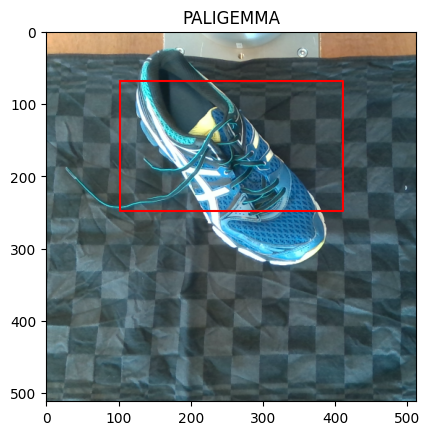

In [17]:
# scale the bbox with the image dimensions
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title("PALIGEMMA")
boxes, labels = parse_paligemma_bbox_and_labels(output)
boxes[..., 0] *= (image.shape[0])
boxes[..., 1] *= image.shape[1]
boxes[..., 2] *= image.shape[0]
boxes[..., 3] *= image.shape[1]
for box in boxes:
    box = [round(x) for x in box]
    plt.plot([box[1], box[3], box[3], box[1], box[1]], [box[0], box[0], box[2], box[2], box[0]], color="red")

## Grounding DINO

In [5]:
from transformers import AutoProcessor, GroundingDinoForObjectDetection
from PIL import Image
import requests

gdino_processor = AutoProcessor.from_pretrained("IDEA-Research/grounding-dino-base")
gdino_model = GroundingDinoForObjectDetection.from_pretrained("IDEA-Research/grounding-dino-base").cuda()


2024-06-13 18:07:51.062681: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-13 18:07:51.508536: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-13 18:07:52.639241: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Detected 1 with confidence 0.91 at location [167.4, 111.6, 678.8, 401.6]


Text(0.5, 1.0, 'Grounding DINO')

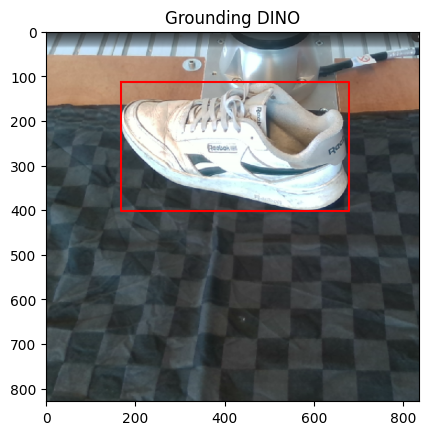

In [8]:
import torch
text = "shoe."

inputs = gdino_processor(images=Image.fromarray(image), text=text, return_tensors="pt").to("cuda")
with torch.inference_mode():
    outputs = gdino_model(**inputs)

# convert outputs (bounding boxes and class logits) to COCO API
target_sizes = torch.tensor([image.shape[:2]])
results = gdino_processor.image_processor.post_process_object_detection(
    outputs, threshold=0.2, target_sizes=target_sizes
)[0]
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 1) for i in box.tolist()]
    print(f"Detected {label.item()} with confidence " f"{round(score.item(), 2)} at location {box}")

import matplotlib.pyplot as plt
plt.imshow(image)
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 1) for i in box.tolist()]
    plt.plot([box[0], box[2], box[2], box[0], box[0]], [box[1], box[1], box[3], box[3], box[1]], color="red")
plt.title("Grounding DINO")

## ACTUAL LABELING

In [26]:
# create bboxes for the coco dataset
coco_dataset = CocoKeypointsDataset(**json.load(open(dataset_path)))
image_id_to_image_dict = {image.id: image for image in coco_dataset.images}

In [27]:
CLASS = "mug"
MODEL = "DINO"


bboxes = []
inflated_bboxes = []
masks = []
images = []
polygon_masks = []
original_masks = []

indices_to_remove = []
with torch.inference_mode():
    for i in tqdm.trange(0, len(coco_dataset.annotations)):
        annotation = coco_dataset.annotations[i]
        image_id = annotation.image_id
        image_path = image_id_to_image_dict[image_id].file_name
        image = Image.open(str(pathlib.Path(dataset_path).parent / image_path))
        image = np.array(image)

        keypoints = annotation.keypoints
        keypoints_uv = np.array([(keypoints[i], keypoints[i+1]) for i in range(0, len(keypoints), 3)])
    
        if MODEL == "PALIGEMMA":
            resized_image = Image.fromarray(image)
            resized_image.resize((448, 448))

            prompt = f"detect {CLASS}" # template for paligemma.
            inputs = paligemma_processor(text=prompt, images=np.array(resized_image)[...,:3], return_tensors="pt")
            inputs = {name: tensor.cuda() for name, tensor in inputs.items()}
            generate_ids = paligemma_model.generate(**inputs, max_length=2000)
            output = paligemma_processor.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
            boxes, labels = parse_paligemma_bbox_and_labels(output)

            if len(boxes) == 0:
                # remove the annotation , probably invisible
                indices_to_remove.append(i)
                print("no bbox found")
                continue

            bbox = boxes[0]
            bbox = bbox * image.shape[0] # scale the bbox to the image size

            # yxyx to xyxy
            bbox = [bbox[1], bbox[0], bbox[3], bbox[2]]
            bbox = [round(x) for x in bbox]
        elif MODEL == "DINO":
            text = f"{CLASS}." # the DOT is important!!
            inputs = gdino_processor(images=Image.fromarray(image), text=text, return_tensors="pt").to("cuda")
            outputs = gdino_model(**inputs)

            # convert outputs (bounding boxes and class logits) to COCO API
            target_sizes = torch.tensor([image.shape[:2]])
            results = gdino_processor.image_processor.post_process_object_detection(
                outputs, threshold=0.35, target_sizes=target_sizes # manually tuned threshold
            )[0]

            if len(results["scores"]) == 0:
                # remove the annotation , probably invisible
                indices_to_remove.append(i)
                print("no bbox found")
                continue
  
            # box with highest score
            # order results by score
            results = sorted(zip(results["scores"], results["labels"], results["boxes"]), key=lambda x: x[0], reverse=True)
            score, label, box = results[0] 
            #print(score)   
            bbox = [round(i) for i in box.tolist()]
        else:
            raise ValueError(f"model {MODEL} not supported")

        # pad the bbox with 10 pixels on all sides, but clip for image size
        padding = 20
        inflated_bbox = [max(0, bbox[0] - padding), max(0, bbox[1] - padding), min(image.shape[0], bbox[2] + padding), min(image.shape[1], bbox[3] + padding)]
        inflated_bbox = np.array(inflated_bbox)

        sam_predictor.set_image(np.array(image))
        # detect using bbox
        mask,_,_ = sam_predictor.predict(
            box=inflated_bbox,
            #point_coords=keypoints_uv,
            point_labels = np.array([1] * len(keypoints_uv)),
            multimask_output=False,
        )
        mask = mask[0]
        # use the inflated bbox as mask to set the outer region to zeros
        mask_mask = np.zeros_like(mask)
        mask_mask[bbox[1]:bbox[3], bbox[0]:bbox[2]] = 1
        mask = mask * mask_mask
        
        # remove small, disconnected segments of the mask
        original_mask = np.copy(mask)
        import cv2
        mask = mask.astype(np.uint8)  * 1
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9,9)))
        # close holes in the mask
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (21,21)))

        # get polygon and annotation format
        mask_obj = BinarySegmentationMask(mask > 0.5)
        annotation.segmentation = mask_obj.as_compressed_rle
        annotation.area = mask_obj.area

        # bbox to xywh format
        bbox_xywh = [bbox[0], bbox[1], bbox[2] - bbox[0], bbox[3] - bbox[1]]
        annotation.bbox = bbox_xywh

        if i % 500 == 0:
            images.append(image)
            original_masks.append(original_mask)
            masks.append(mask)
            bboxes.append(bbox)
            inflated_bboxes.append(inflated_bbox)
            polygon_masks.append(mask_obj.as_single_polygon)



# rmeove annotations for which no bbox was found (most likely occluded)
indices_to_remove = set(indices_to_remove)
new_annotations = [annotation for i, annotation in enumerate(coco_dataset.annotations) if i not in indices_to_remove]
coco_dataset.annotations = new_annotations

    

100%|██████████| 351/351 [03:51<00:00,  1.51it/s]


IndexError: list index out of range

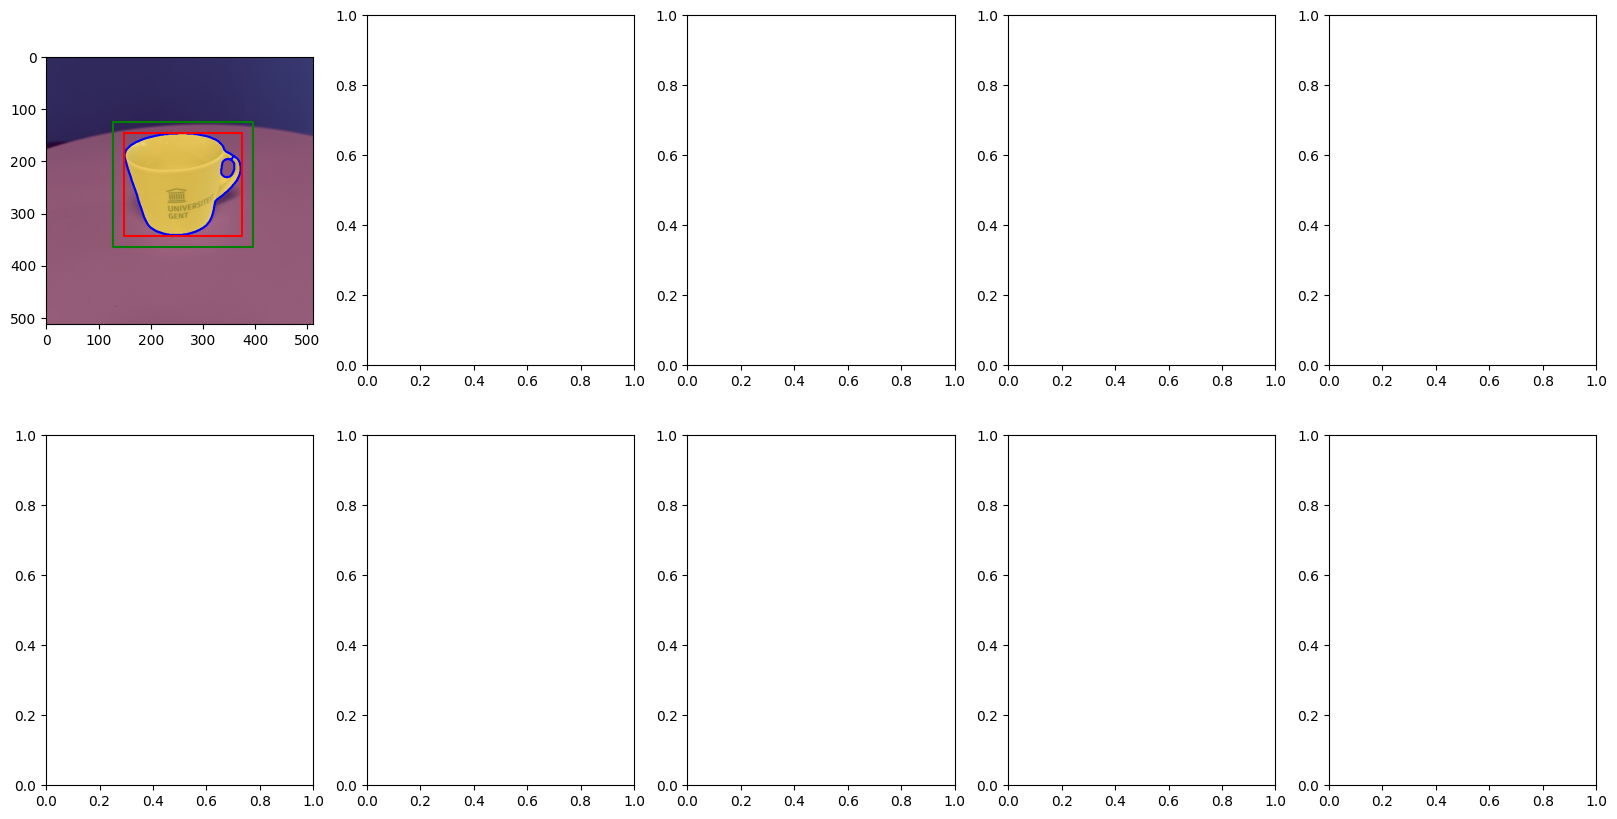

In [28]:
# visualize the mask on the image create a 2x 5 grid

import matplotlib.pyplot as plt
from airo_dataset_tools.segmentation_mask_converter import BinarySegmentationMask

fig, axs = plt.subplots(2, 5, figsize=(20, 10))

for i in range(10):
    image = images[i]
    mask = masks[i]
    original_mask = original_masks[i]
    bbox = bboxes[i]
    inflated_bbox = inflated_bboxes[i]

    axs[i // 5, i % 5].imshow(image)    
    #axs[i // 5, i % 5].imshow(mask, alpha=0.5)
    axs[i // 5, i % 5].imshow(mask, alpha=0.5)
    # visualize the polygon mask, which is a sequence of (x,y) points
    polygon_mask = polygon_masks[i]
    if polygon_mask:
        mask = np.array(polygon_mask)
        mask = mask.reshape(-1, 2)
        axs[i // 5, i % 5].plot(mask[:, 0], mask[:, 1], color="blue")
    # reshape into (n, 2)
    axs[i // 5, i % 5].plot([bbox[0], bbox[2], bbox[2], bbox[0], bbox[0]], [bbox[1], bbox[1], bbox[3], bbox[3], bbox[1]], color="red")
    axs[i // 5, i % 5].plot([inflated_bbox[0], inflated_bbox[2], inflated_bbox[2], inflated_bbox[0], inflated_bbox[0]], [inflated_bbox[1], inflated_bbox[1], inflated_bbox[3], inflated_bbox[3], inflated_bbox[1]], color="green")

    

In [29]:
# save the annotations 
json.dump(coco_dataset.model_dump(), open(dataset_path.replace(".json", "_sam_masked.json"), "w"), indent=4)

/home/tlips/.conda/envs/dsd/lib/python3.10/site-packages/pydantic/main.py:308: UserWarning: Pydantic serializer warnings:
  Expected `tuple[float, float, float, float]` but got `list` - serialized value may not be as expected
  Expected `tuple[float, float, float, float]` but got `list` - serialized value may not be as expected
  Expected `tuple[float, float, float, float]` but got `list` - serialized value may not be as expected
  Expected `tuple[float, float, float, float]` but got `list` - serialized value may not be as expected
  Expected `tuple[float, float, float, float]` but got `list` - serialized value may not be as expected
  Expected `tuple[float, float, float, float]` but got `list` - serialized value may not be as expected
  Expected `tuple[float, float, float, float]` but got `list` - serialized value may not be as expected
  Expected `tuple[float, float, float, float]` but got `list` - serialized value may not be as expected
  Expected `tuple[float, float, float, float]`

In [ ]:
dataset_path